In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt
from datasets import DirectionRGB

In [21]:
args = {}
args["data_dir"] = "data/Directions01"
args["data"] = "direction"
args["lr"] = 0.001
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [35]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"]
        )

In [23]:
import timm
import torch.nn.functional as F

class WarmUpResNet(nn.Module):
    def __init__(
        self, backbone="resnet18"
    ):
        super(WarmUpResNet, self).__init__()
        self.backbone = timm.create_model('resnet18', pretrained=True, num_classes=256)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [24]:
device = utils.get_device("mps")
model = WarmUpResNet()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [25]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [26]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 128, 128]) torch.Size([4, 4])


In [28]:
from tqdm import tqdm
def train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, num_epochs):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs.repeat(1,3,1,1))
                        loss = loss_fn(outputs, labels)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 5)

Val Epoch 1/5: 100%|██████████| 24/24 [00:22<00:00,  1.09batch/s]


Epoch 1/5 -> Train Loss: 0.0412, Val Loss: 0.0016


Val Epoch 2/5: 100%|██████████| 24/24 [00:22<00:00,  1.09batch/s]


Epoch 2/5 -> Train Loss: 0.0032, Val Loss: 0.0001


Val Epoch 3/5: 100%|██████████| 24/24 [00:22<00:00,  1.08batch/s]


Epoch 3/5 -> Train Loss: 0.0002, Val Loss: 0.0000


Val Epoch 4/5: 100%|██████████| 24/24 [00:22<00:00,  1.08batch/s]


Epoch 4/5 -> Train Loss: 0.0002, Val Loss: 0.0000


Val Epoch 5/5: 100%|██████████| 24/24 [00:22<00:00,  1.08batch/s]

Epoch 5/5 -> Train Loss: 0.0000, Val Loss: 0.0000


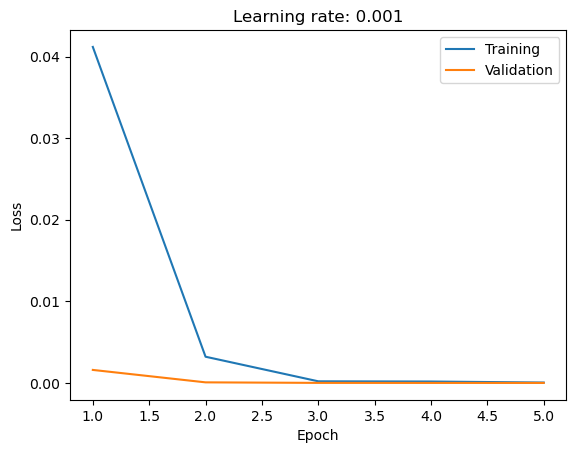

In [29]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [37]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [38]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.repeat(1,3,1,1))
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.0000


In [39]:
from sklearn.metrics import roc_auc_score, accuracy_score
print(f"AUC: {roc_auc_score(targets, outputs)}")
print(f"ACC: {accuracy_score(targets, (outputs>0.5).float().numpy())}")

AUC: 1.0
ACC: 1.0


In [46]:
def map_logit_class(output):
    DirectionRGB.inverse_label_mapping
    return DirectionRGB.inverse_label_mapping[output.argmax().item()]

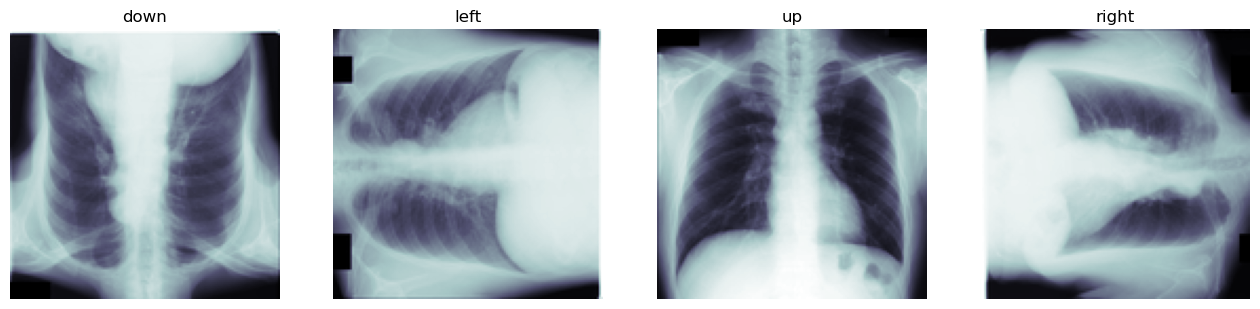

In [57]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


def get_grad_cam(input_tensor):
    input_tensor = input_tensor.unsqueeze(dim=0).repeat(1,3,1,1)
    target_layers = [model.backbone.layer4[-1],model.backbone.layer4[-2]]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(image_to_arrag(input_tensor.squeeze()), grayscale_cam, use_rgb=True)
        return visualization

fig = plt.figure(figsize=(16,4))
fig.add_subplot(141)
plt.imshow(image_to_arrag(inputs[0]), cmap=plt.cm.bone)
plt.title(map_logit_class(outputs[0]))
plt.axis("off")
fig.add_subplot(142)
plt.imshow(image_to_arrag(inputs[5]), cmap=plt.cm.bone)
plt.title(map_logit_class(outputs[5]))
plt.axis("off")
fig.add_subplot(143)
plt.imshow(image_to_arrag(inputs[2]), cmap=plt.cm.bone)
plt.title(map_logit_class(outputs[2]))
plt.axis("off")
fig.add_subplot(144)
plt.imshow(image_to_arrag(inputs[6]), cmap=plt.cm.bone)
plt.title(map_logit_class(outputs[6]))
plt.axis("off")
plt.show()